In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
    
# Some constants 
INPUT_FOLDER = r'C:\Users\CXR\Project\5-19download\dicom\SCT205\S40'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(os.path.join(path , s)) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 19

In [8]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [9]:
first_patient = load_scan(INPUT_FOLDER)
first_patient_pixels = get_pixels_hu(first_patient)

In [10]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    print(scan[0].SliceThickness,scan[0].PixelSpacing)
    spacing = [scan[0].SliceThickness] + list(scan[0].PixelSpacing)
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [11]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])

1.0 [0.79296875, 0.79296875]


In [12]:

def plot_3d(image,fig,ax, image_label = None, threshold=-300,view_angle = -75):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    if image_label is not None:
        lp  = image_label.transpose(2,1,0)
        lp = lp[:,:,::-1]
        vertslp, faceslp,norm, val = measure.marching_cubes_lewiner(lp, threshold)    
    
    verts, faces,norm, val = measure.marching_cubes_lewiner(p, threshold)
    
    
    
    ax.view_init(azim=view_angle) 
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    mesh1 = Poly3DCollection(vertslp[faceslp], alpha=0.1)
#     ax = Axes3D(fig)
#     axx=a()
#     azm=axx.azim
#     ele=axx.elev
#     dst=axx.dist *0.7      # ALWAYS GIVES 10

    
    face_color = [0.8, 0.8, 1]
    face_colorlp = [1, 0.6, 0.6]

    mesh.set_facecolor(face_color)
    mesh1.set_facecolor(face_colorlp)
    ax.add_collection3d(mesh)
    ax.add_collection3d(mesh1)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.axis('off') 
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

   

In [13]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [14]:
from PIL import Image
import numpy as np
from natsort import natsorted
lesionpath = r'C:\Users\CXR\Project\5-19download\Leave\SCT205\S40'
leavepath = r'C:\Users\CXR\Project\5-19download\lesion\SCT205\S40'
def redSeg_result(imgpath = '',leavepath = ''):
    imgs = []
    lesionPath = natsorted(os.listdir(imgpath))
    leavePath = natsorted(os.listdir(leavepath))
    for n,file in enumerate(lesionPath):
        if n < len(leavePath):
            leaveimg = Image.open(os.path.join(leavepath,leavePath[n])).convert('L')
        img = Image.open(os.path.join(imgpath,file)).convert('L')
        img = np.array(img)
        if n < len(leavePath):
            leaveimg = np.array(leaveimg)
            img = img[:,512:] * leaveimg[:,512:]
        else:
            img = img[:,512:]
        img = np.where(img>0,1,0).astype('uint8')
        imgs.append(np.expand_dims(img,axis = 0))
    imgs = np.concatenate(imgs,axis =0)
    return imgs
imgs = redSeg_result(lesionpath,leavepath)
label_resampled, spacing = resample(imgs, first_patient, [1,1,1])

1.0 [0.79296875, 0.79296875]


In [15]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

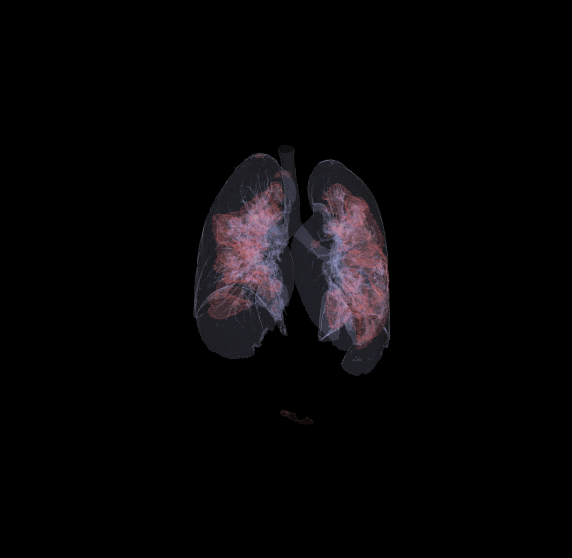

In [16]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_3d(segmented_lungs,fig,ax,label_resampled,0)
plt.show()
fig.savefig(r'C:\Users\CXR\Project\5-19download\dicom\SCT205\fig.png')

In [ ]:
from matplotlib.animation import FuncAnimation
threshold = 0
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Position the scan upright, 
# so the head of the patient would be at the top facing the camera
p = segmented_lungs.transpose(2,1,0)
p = p[:,:,::-1]
if label_resampled is not None:
    lp  = label_resampled.transpose(2,1,0)
#         lp = lp[:,:,::-1]
    vertslp, faceslp,norm, val = measure.marching_cubes_lewiner(lp, threshold)    

verts, faces,norm, val = measure.marching_cubes_lewiner(p, threshold)



ax.view_init(azim=0) 
# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.1)
mesh1 = Poly3DCollection(vertslp[faceslp], alpha=0.1)


face_color = [0.5, 0.5, 1]
face_colorlp = [1, 0.5, 0.5]

mesh.set_facecolor(face_color)
mesh1.set_facecolor(face_colorlp)
ax.add_collection3d(mesh)
ax.add_collection3d(mesh1)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
plt.axis('off') 
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# plot_3d(segmented_lungs,fig,ax,label_resampled,0)
def rotate(angle): 
    ax.view_init(azim=angle) 
rot_animation =FuncAnimation(fig, rotate, frames=np.arange(0,60,2),interval=100) 
rot_animation.save(r'C:\Users\CXR\Project\5-9download\rotation.gif', dpi=80, writer='imagemagick') 

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
